# TCC


## Imports


In [1]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from nltk.stem.porter import *
from nltk.stem import *
import xgboost as xgb
import pandas as pd
import numpy as np
import spacy.cli
import gensim
import spacy
import nltk
import pickle
import warnings

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import json

spacy.cli.download("pt_core_news_sm")
nltk.download('wordnet')
nltk.download('omw-1.4')

warnings.filterwarnings("ignore")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Carregando dados:

In [4]:
data = pd.read_json('output_classifier.json')

X = data['text']
y = data['label']

In [5]:
y[26]

['yes']

In [6]:
X[26]

'GOVERNO DO ESTADO DO ACRE SECRETARIA DE ESTADO DE EDUCAÇÃO, CULTURA E ESPORTES EDITAL TOMADA DE PREÇO N° 01/2021 Aviso de Licitação  A Escola Coronel Manoel Fontenele de Castro, de acordo com as disposições da Lei n/ 8.666/93 e suas alterações, torna público que realizará  a LICITAÇÃO a seguir caracterizada: Objeto: Aquisição de material de expediente, proteção, limpeza, higiene e material permanente. Para atender escola Coronel Manoel Fontenele de Castro, Retirada do edital: Escola Coronel Manoel Fontenele de Castro, no horário  de 8hs às 13hs, no período de 03 de agosto de 2021 à 17 de agosto de  2021. Data de Abertura das propostas: 20/08/2021 as 9:30h, Av. Dr. Manoel  Marinho Monte, nº 1328, bairro Ferreira Silva, Brasiléia – AC. Brasiléia – Acre, 30 de julho de 2021. Vanessa Machado Salvador  Rodrigues Presidente da CPL '

In [7]:
len(X)

6499

In [8]:
len(y)

6499

## Pré-processamento:

- Transformar 'no' e 'yes' em valores 0 e 1 respectivamente.
- Lematização.
- All text in Lower Case.


In [9]:
def convert_label(label):
    if label[0] == 'no':
        return 0
    return 1

In [10]:
X = data['text']
y = data['label'].map(convert_label)

In [11]:
X[26]

'GOVERNO DO ESTADO DO ACRE SECRETARIA DE ESTADO DE EDUCAÇÃO, CULTURA E ESPORTES EDITAL TOMADA DE PREÇO N° 01/2021 Aviso de Licitação  A Escola Coronel Manoel Fontenele de Castro, de acordo com as disposições da Lei n/ 8.666/93 e suas alterações, torna público que realizará  a LICITAÇÃO a seguir caracterizada: Objeto: Aquisição de material de expediente, proteção, limpeza, higiene e material permanente. Para atender escola Coronel Manoel Fontenele de Castro, Retirada do edital: Escola Coronel Manoel Fontenele de Castro, no horário  de 8hs às 13hs, no período de 03 de agosto de 2021 à 17 de agosto de  2021. Data de Abertura das propostas: 20/08/2021 as 9:30h, Av. Dr. Manoel  Marinho Monte, nº 1328, bairro Ferreira Silva, Brasiléia – AC. Brasiléia – Acre, 30 de julho de 2021. Vanessa Machado Salvador  Rodrigues Presidente da CPL '

In [12]:
y[26]

1

In [13]:
# Pré-processamento dos dados.
stemmer = PorterStemmer()

# Lematização
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Colocando todas as palavras para caixa baixa.
def preprocess(text):
  return lemmatize_stemming(text.lower())

In [14]:
class Text2TfIdfTransformer(BaseEstimator):
    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, x, y=None):
        x = x.apply(lambda x : preprocess(x))
        self._model.fit(x)
        return self

    def transform(self, x):
        return self._model.transform(x)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

X = TfidfVectorizer().fit_transform(X)

## Algoritmos:

### Preparar Dados

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

In [17]:
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

0    602
1    602
Name: label, dtype: int64


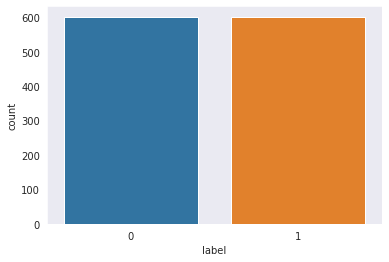

In [18]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)

# ver o balanceamento das classes nos dados de treino
print(pd.Series(y_res).value_counts())

# plotar a nova distribuição de classes nos dados de treino
sns.countplot(y_res);

0    1692
1     258
Name: label, dtype: int64


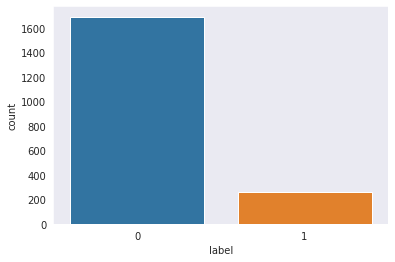

In [19]:
# ver o balanceamento das classes nos dados de testes
print(pd.Series(y_test).value_counts())

# plotar a nova distribuição de classes nos dados de testes
sns.countplot(y_test);

In [20]:
folds = 10
kfold = StratifiedKFold(folds)

In [21]:
def evaluate_model(model, predicts, y_val):
    accuracy = accuracy_score(y_val, predicts)
    scores = precision_recall_fscore_support(y_val, predicts, average='macro')
    print(f'- Precision: {scores[0]}\n- Recall: {scores[1]}\n- F1Score: {scores[2]}\n- Acurácia: {accuracy}')

### XGBoost:

Treinando o modelo de XGBoost usando o GridSearchCV com a validação cruzada e procurando os melhores hiper-parametros para nosso modelo.

F1 Score no treino: 0.9833838546502746

Na validação:
- Precision: 0.9505768926821558
- Recall: 0.989787783825389
- F1Score: 0.9689771681832469
- Acurácia: 0.9851282051282051

#### GridSearchCV

In [ ]:
pl_xgb_tf_idf = Pipeline(steps=[('clf', xgb.XGBClassifier(objective='binary:logistic'))])
params = {'clf__min_child_weight': [1, 5], 'clf__subsample': [0.6, 0.8],
          'clf__colsample_bytree': [0.6, 1.0], 'clf__max_depth': [3, 4] }
grid = GridSearchCV(estimator=pl_xgb_tf_idf, param_grid=params, scoring='f1_macro', cv=folds, verbose=4)
grid.fit(X_res, y_res)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.983 total time=   4.3s
[CV 2/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.983 total time=   3.2s
[CV 3/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.983 total time=   3.2s
[CV 4/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.983 total time=   3.2s
[CV 5/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.983 total time=   3.2s
[CV 6/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.983 total time=   3.2s
[CV 7/10] END clf__colsample_bytree=0.6, clf__max_depth=3, clf__min_child_weight=1, clf__subsample=0.6;, score=0.992 tota

GridSearchCV(cv=10, estimator=Pipeline(steps=[('clf', XGBClassifier())]),
             param_grid={'clf__colsample_bytree': [0.6, 1.0],
                         'clf__max_depth': [3, 4],
                         'clf__min_child_weight': [1, 5],
                         'clf__subsample': [0.6, 0.8]},
             scoring='f1_macro', verbose=4)

In [ ]:
import joblib

#save your model or results
# joblib.dump(grid, 'grid_xgb_tf_idf.pkl')

#load your model for further usage
grid = joblib.load("grid_xgb_tf_idf.pkl")

['grid_xgb_tf_idf.pkl']

In [ ]:
print(f'Melhor min_child_weight: {grid.best_params_["clf__min_child_weight"]}. Melhor colsample_bytree: {grid.best_params_["clf__colsample_bytree"]}.')
print(f'Melhor subsample: {grid.best_params_["clf__subsample"]}.  Melhor max_depth: {grid.best_params_["clf__max_depth"]}.')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor min_child_weight: 1. Melhor colsample_bytree: 0.6.
Melhor subsample: 0.6.  Melhor max_depth: 3.
Resultou no F1 0.9833838546502746 durante o 10-fold


#### Treinando o modelo XGBoost com os melhores parametros

In [ ]:
best_params = grid.best_params_

##### Overfiting


In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


kf = KFold(n_splits=70)
mae_train = []
mae_test = []

X_ = X_res
Y_ = y_res

for train_index, test_index in kf.split(X_):
    X_train_, X_test_ = X_[train_index], X_[test_index]
    y_train_, y_test_ = Y_[train_index], Y_[test_index]

    pl_xgb_tf_idf = Pipeline(steps=[('clf', xgb.XGBClassifier(
                             objective='binary:logistic',
                             max_depth=best_params['clf__max_depth'],
                             subsample=best_params['clf__subsample'],
                             min_child_weight=best_params['clf__min_child_weight'],
                             colsample_bytree=best_params['clf__colsample_bytree'])
                         )])
    pl_xgb_tf_idf.fit(X_train_, y_train_)

    y_train_pred = pl_xgb_tf_idf.predict(X_train_)
    y_test_pred = pl_xgb_tf_idf.predict(X_test_)
    mae_train.append(mean_absolute_error(y_train_, y_train_pred))
    mae_test.append(mean_absolute_error(y_test_, y_test_pred))

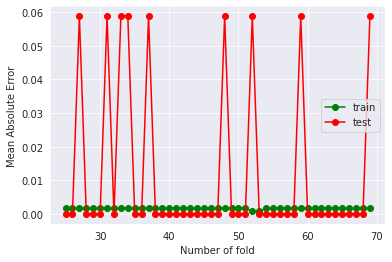

In [ ]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='green', label='train')
plt.plot(folds, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.show()

##### Melhor Modelo:

In [ ]:
pl_xgb_tf_idf = Pipeline(steps=[('clf', xgb.XGBClassifier(
                             objective='binary:logistic',
                             max_depth=best_params['clf__max_depth'],
                             subsample=best_params['clf__subsample'],
                             min_child_weight=best_params['clf__min_child_weight'],
                             colsample_bytree=best_params['clf__colsample_bytree'])
                         )])
pl_xgb_tf_idf.fit(X_res, y_res)

Pipeline(steps=[('clf', XGBClassifier(colsample_bytree=1.0, subsample=0.6))])

In [ ]:
filename = 'xgb_tf_idf.sav'
pickle.dump(pl_xgb_tf_idf, open(filename, 'wb'))

In [ ]:
pl_xgb_tf_idf = pickle.load(open("xgb_tf_idf.sav", 'rb'))

In [ ]:
pred = pl_xgb_tf_idf.predict(X_test)
evaluate_model(pl_xgb_tf_idf, pred, y_test)

- Precision: 0.9505768926821558
- Recail: 0.989787783825389
- F1Score: 0.9689771681832469
- Acurácia: 0.9851282051282051


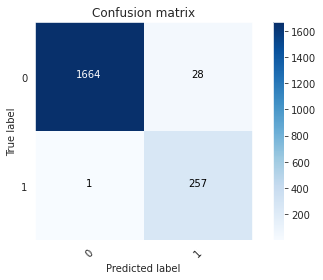

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, y.unique())

### Regressão Logistica

Treinando o modelo de Regressão Logistica usando o GridSearchCV com a validação cruzada e procurando os melhores hiper-parametros para nosso modelo.

F1 Score no treino: 0.9825426768296455

Na validação: 
- Precision: 0.9392632432466408
- Recall: 0.9802627961955028
- F1Score: 0.9584079629199196
- Acurácia: 0.98

O f1 score foi maior com os dados de validação.

In [ ]:
pl_log_regression_tf_idf = Pipeline(steps=[('logistic', LogisticRegression(random_state=0))])
model_params = {
    'logistic__random_state': [0],
    'logistic__C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2'],
    'logistic__multi_class': ['ovr'],
    'logistic__solver': ['sag', 'saga', 'lbfgs']
}
grid = GridSearchCV(estimator=pl_log_regression_tf_idf, param_grid=model_params, scoring='f1_macro', cv=folds)
grid.fit(X_res, y_res)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('logistic',
                                        LogisticRegression(random_state=0))]),
             param_grid={'logistic__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'logistic__multi_class': ['ovr'],
                         'logistic__penalty': ['l1', 'l2'],
                         'logistic__random_state': [0],
                         'logistic__solver': ['sag', 'saga', 'lbfgs']},
             scoring='f1_macro')

In [ ]:
print(f'Melhor C: {grid.best_params_["logistic__C"]}. Melhor penalty: {grid.best_params_["logistic__penalty"]}. Melhor solver: {grid.best_params_["logistic__solver"]}')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor C: 100. Melhor penalty: l2. Melhor solver: lbfgs
Resultou no F1 0.9825426768296455 durante o 10-fold


#### Treinando o modelo LogisticRegression usando os melhores parametros

In [ ]:
best_params = grid.best_params_

In [ ]:
pl_log_regression_tf_idf = Pipeline(steps=[('logistic', LogisticRegression(
                             C=best_params["logistic__C"],
                             penalty=best_params["logistic__penalty"],
                             solver=best_params["logistic__solver"],
                             multi_class='ovr', random_state=0)
                         )])
pl_log_regression_tf_idf.fit(X_res, y_res)

Pipeline(steps=[('logistic',
                 LogisticRegression(C=100, multi_class='ovr', random_state=0))])

In [ ]:
pred = pl_log_regression_tf_idf.predict(X_test)
evaluate_model(pl_log_regression_tf_idf, pred, y_test)

- Precision: 0.9392632432466408
- Recall: 0.9802627961955028
- F1Score: 0.9584079629199196
- Acurácia: 0.98


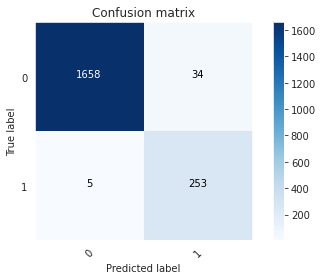

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, y.unique())

A matriz de confusão acima pode ser lida da seguinte forma:
* Na diagonal principal, temos os acertos em cada classe;
* Fora da diagonal, temos as previsões incorretas.

### Árvore de Decisão:

Treinando o modelo de Árvore de Decisão usando o GridSearchCV com a validação cruzada e procurando os melhores hiper-parametros para nosso modelo.

F1 Score no treino: 0.9850596153485279

Na validação: 
- Precision: 0.9274879519658705
- Recall: 0.9834171752157898
- F1Score: 0.9528745453266318
- Acurácia: 0.9769230769230769

In [ ]:
pl_dec_tree_tf_idf = Pipeline(steps=[('clf', DecisionTreeClassifier())])
params = {'clf__criterion':['gini','entropy'],'clf__max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid = GridSearchCV(estimator=pl_dec_tree_tf_idf, param_grid=params, scoring='f1_macro', cv=folds)
grid.fit(X_res, y_res)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clf', DecisionTreeClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15,
                                            20, 30, 40, 50, 70, 90, 120, 150]},
             scoring='f1_macro')

In [ ]:
print(f'Melhor criterion: {grid.best_params_["clf__criterion"]}. Melhor max_depth: {grid.best_params_["clf__max_depth"]}.')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor criterion: gini. Melhor max_depth: 5.
Resultou no F1 0.9850596153485279 durante o 10-fold


#### Treinando o modelo Árvore de Decisão usando os melhores parametros

In [ ]:
best_params = grid.best_params_

In [ ]:
pl_dec_tree_tf_idf = Pipeline(steps=[('clf', DecisionTreeClassifier(criterion=best_params['clf__criterion'], max_depth=best_params['clf__max_depth']))])
pl_dec_tree_tf_idf.fit(X_res, y_res)

Pipeline(steps=[('clf', DecisionTreeClassifier(max_depth=5))])

In [ ]:
pred = pl_dec_tree_tf_idf.predict(X_test)
evaluate_model(pl_dec_tree_tf_idf, pred, y_test)

- Precision: 0.9274879519658705
- Recall: 0.9834171752157898
- F1Score: 0.9528745453266318
- Acurácia: 0.9769230769230769


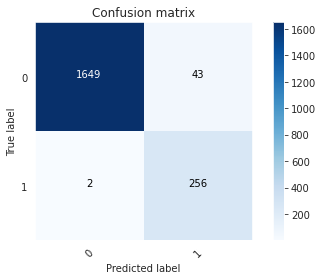

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, y.unique())

### Random Forest:

Treinando o modelo de Random Forest usando o GridSearchCV com a validação cruzada e procurando os melhores hiper-parametros para nosso modelo.

F1 Score no treino: 0.9775544039171477

Na validação: 
- Precision: 0.8836139169472503
- Recall: 0.9697894331738963
- F1Score: 0.9198954944296559
- Acurácia: 0.958974358974359




In [ ]:
pl_random_forest_tf_idf = Pipeline(steps=[('clf', RandomForestClassifier(random_state=42))])
params = { 
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['auto', 'log2'],
    'clf__max_depth' : [4,8],
    'clf__criterion' :['gini', 'entropy']
}
grid = GridSearchCV(estimator=pl_random_forest_tf_idf, param_grid=params, scoring='f1_macro', cv=folds) 
grid.fit(X_res, y_res)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [4, 8],
                         'clf__max_features': ['auto', 'log2'],
                         'clf__n_estimators': [200, 500]},
             scoring='f1_macro')

In [ ]:
print(f'Melhor n_estimators: {grid.best_params_["clf__n_estimators"]}. Melhor max_features: {grid.best_params_["clf__max_features"]}.')
print(f'Melhor max_depth: {grid.best_params_["clf__max_depth"]}. Melhor criterion: {grid.best_params_["clf__criterion"]}.')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor n_estimators: 500. Melhor max_features: auto.
Melhor max_depth: 4. Melhor criterion: gini.
Resultou no F1 0.9775544039171477 durante o 10-fold


#### Treinando o modelo Random Forest usando os melhores parametros

In [ ]:
best_params = grid.best_params_

In [ ]:
pl_random_forest_tf_idf = Pipeline(steps=[('clf', RandomForestClassifier(
                             random_state=42,
                             n_estimators=best_params['clf__n_estimators'],
                             max_features=best_params['clf__max_features'],
                             max_depth=best_params['clf__max_depth'],
                             criterion=best_params['clf__criterion'])
                         )])
pl_random_forest_tf_idf.fit(X_res, y_res)

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_depth=4, n_estimators=500,
                                        random_state=42))])

In [ ]:
pred = pl_random_forest_tf_idf.predict(X_test)
evaluate_model(pl_random_forest_tf_idf, pred, y_test)

- Precision: 0.8836139169472503
- Recall: 0.9697894331738963
- F1Score: 0.9198954944296559
- Acurácia: 0.958974358974359


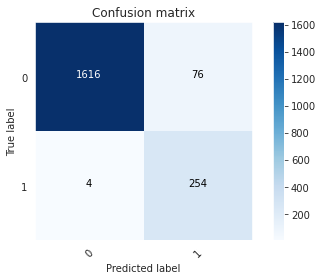

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, y.unique())

### Bert

Treinando o modelo de Bertimbau com a validação cruzada.

F1 Score no treino: 0.9878530558192912

Na validação: 
- Acurácia: 98.67%
- Recall: 98.67%
- F1-score: 98.67%
- Precision: 98.69%

#### Imports

In [22]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 36.6 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 6.6 MB 34.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [23]:
import csv
import random
import nltk
nltk.download('punkt')

import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from torch.utils.data import DataLoader
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
% matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Preparando os dados:

In [80]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [81]:
def convert_label(label):
    if label[0] == 'no':
        return 0
    return 1

In [82]:
# data = pd.read_json('output_classifier.json')
import json

with open('output_classifier_binary.json', 'r') as f:
    data = json.load(f)

In [83]:
count = 900
data_ = []
for obj in data:
    if obj['label'] == 0 and count > 0:
        data_.append(obj)
        count -= 1
    elif obj['label'] == 1:
        data_.append(obj)


In [84]:
len(list(filter(lambda obj: obj['label'] == 0, data_)))

900

In [85]:
len(list(filter(lambda obj: obj['label'] == 1, data_)))

860

In [86]:
data = data_
random.shuffle(data, lambda: 0.5)
X = [obj['text'] for obj in data]
y = [obj['label'] for obj in data]
data = [{'X': act, 'y': class_} for (act, class_) in zip(X, y)]

#### Separar dados

In [87]:
y = list(map(lambda obj: obj['y'] == 1, data))
treino, teste = train_test_split(data, test_size=0.3, stratify=y, shuffle=True, random_state=17)

In [88]:
y = list(map(lambda obj: obj['y'] == 1, treino))
treino, validacao = train_test_split(treino, test_size=0.2, stratify=y, shuffle=True, random_state=17)

In [44]:
# class_min = list(filter(lambda obj: obj['y'] == 1, treino))
# class_maj = list(filter(lambda obj: obj['y'] == 0, treino))
# class_maj = class_maj[:len(class_min)]

In [45]:
# treino = class_min + class_maj
# # random.shuffle(treino)

In [46]:
# class_min = list(filter(lambda obj: obj['y'] == 1, validacao))
# class_maj = list(filter(lambda obj: obj['y'] == 0, validacao))
# class_maj = class_maj[:len(class_min)]

In [47]:
# validacao = class_min + class_maj
# random.shuffle(treino)

In [89]:
len(list(filter(lambda obj: obj['y'] == 0, treino)))

504

In [90]:
len(list(filter(lambda obj: obj['y'] == 1, treino)))

481

In [91]:
len(list(filter(lambda obj: obj['y'] == 0, validacao)))

126

In [92]:
len(list(filter(lambda obj: obj['y'] == 1, validacao)))

121

#### Instanciando parânetros da rede neural

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 2
nepochs = 4
batch_size = 8
batch_status = 32
learning_rate = 2e-5

max_length = 128
write_path = 'model'

#### Separando os dados em batches

In [94]:
traindata = DataLoader(treino, batch_size=batch_size)
testdata = DataLoader(teste, batch_size=batch_size)
validationdata = DataLoader(validacao, batch_size=batch_size)

#### Inicilizando tokenizador, modelo, função de erro e otimizador:

In [95]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased',
                                                      num_labels=nclasses,
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)
model.cuda()

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

#### Definindo método de avaliação

In [96]:
def classification_report(y, predicoes):
  acc = accuracy_score(y, predicoes) * 100
  recall = recall_score(y, predicoes, average='weighted') * 100
  f1 = f1_score(y, predicoes, average='weighted') * 100
  precision = precision_score(y, predicoes, average='weighted') * 100
  return "Acurácia: %.2f%%\nRecall: %.2f%%\nF1-score: %.2f%%\nPrecision: %.2f%%" % (acc, recall, f1, precision)


In [97]:
def predict(model, texts):
  inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
  output = model(**inputs)
  return torch.argmax(output.logits, 1)

In [98]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['X'], inp['y']
                  
    pred_labels = predict(model, texts)
    
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

#### Treinamento

In [99]:
max_f1, repeat = 0, 0
status = []
for epoch in range(nepochs):
  model.train()
  losses = []
  train_loss = 0

  for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    # treino
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculate loss
    loss = output.loss
    losses.append(float(loss))

    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
        float(loss), round(sum(losses) / len(losses), 5)))
  
  avg_train_loss = train_loss / len(traindata)  
  
  val_loss = 0
  model.eval()
  for batch_idx, inp in enumerate(validationdata):
    texts, labels = inp['X'], inp['y']

    with torch.no_grad():  
      # validação
      inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
      output = model(**inputs, labels=labels.to(device))

      loss = output.loss
      val_loss += loss.item()

  avg_val_loss = val_loss / len(validationdata)

  status.append(
        {
            'epoch': epoch + 1,
            'training': round(avg_train_loss, 3),
            'validation': round(avg_val_loss,3)
        }
    )

  f1, acc = evaluate(model, validationdata)
  print('F1: ', f1, 'Accuracy: ', acc)
  if f1 > max_f1:
    model.save_pretrained("model")
    max_f1 = f1
    repeat = 0
    print('Saving best model...')

Train Epoch: 0 [32/124 (25%)]	Loss: 0.262009	Total Loss: 0.397150
Train Epoch: 0 [64/124 (51%)]	Loss: 0.691527	Total Loss: 0.290940
Train Epoch: 0 [96/124 (77%)]	Loss: 0.045770	Total Loss: 0.256140
Acurácia: 97.57%
Recall: 97.57%
F1-score: 97.57%
Precision: 97.62%
F1:  0.975710094700529 Accuracy:  0.9757085020242915
Saving best model...
Train Epoch: 1 [32/124 (25%)]	Loss: 0.005200	Total Loss: 0.012970
Train Epoch: 1 [64/124 (51%)]	Loss: 1.002151	Total Loss: 0.034670
Train Epoch: 1 [96/124 (77%)]	Loss: 0.110956	Total Loss: 0.080790
Acurácia: 97.57%
Recall: 97.57%
F1-score: 97.57%
Precision: 97.58%
F1:  0.9757108913519612 Accuracy:  0.9757085020242915
Saving best model...
Train Epoch: 2 [32/124 (25%)]	Loss: 0.002507	Total Loss: 0.008800
Train Epoch: 2 [64/124 (51%)]	Loss: 1.278276	Total Loss: 0.033320
Train Epoch: 2 [96/124 (77%)]	Loss: 0.030214	Total Loss: 0.058510
Acurácia: 98.79%
Recall: 98.79%
F1-score: 98.79%
Precision: 98.79%
F1:  0.9878530558192912 Accuracy:  0.9878542510121457
Sa

In [100]:
df_stats = pd.DataFrame(data=status)
df_status = df_stats.set_index('epoch')
df_status.head()

,training,validation
epoch,,
1,0.209,0.101
2,0.067,0.095
3,0.051,0.073
4,0.027,0.066


In [101]:
import json

with open('./status.json', 'w') as outfile:
    json.dump(status, outfile)

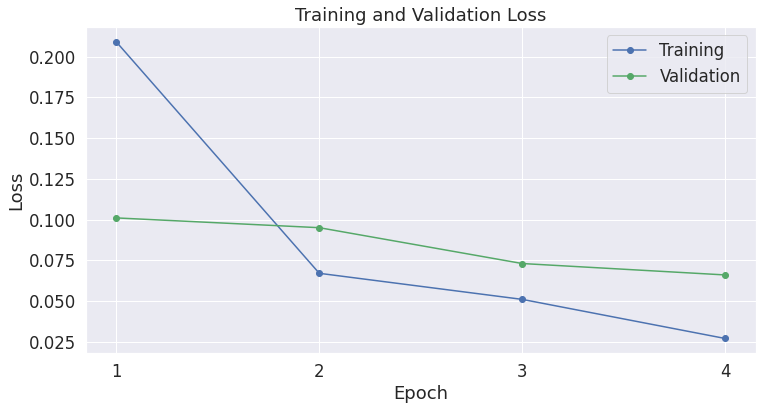

In [102]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_status['training'], 'b-o', label="Training")
plt.plot(df_status['validation'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, nepochs + 1)))

plt.show()

In [103]:
evaluate(model, testdata)


Progress: 0.47 31
Progress: 0.95 63
Acurácia: 98.67%
Recall: 98.67%
F1-score: 98.67%
Precision: 98.69%


(0.9867440889603518, 0.9867424242424242)

In [104]:
predicoes = []
Y = []
for i in teste:
  predicoes.append(predict(model, i['X']).tolist()[0])
  Y.append(i['y'])
print(classification_report(Y, predicoes))

Acurácia: 98.67%
Recall: 98.67%
F1-score: 98.67%
Precision: 98.69%


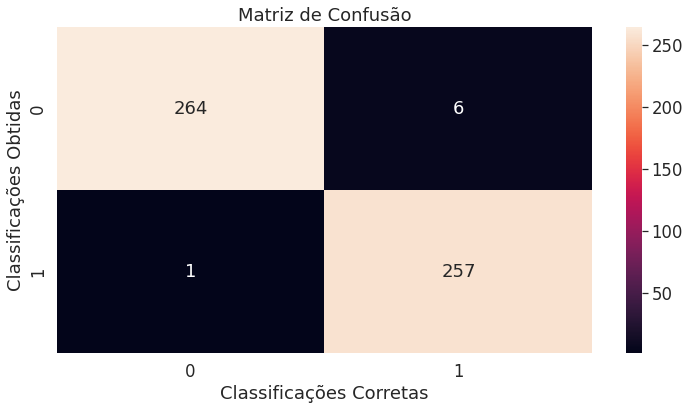

In [105]:
cm = confusion_matrix(Y, predicoes)

ax = sns.heatmap(cm, annot=True, fmt='g');

ax.set_title('Matriz de Confusão');
ax.set_xlabel('Classificações Corretas')
ax.set_ylabel('Classificações Obtidas');
plt.show()

#### Salvando o melhor modelo

In [106]:
!zip -r ./model_bertimbau_best.zip ./model

  adding: model/ (stored 0%)
  adding: model/config.json (deflated 53%)
  adding: model/pytorch_model.bin (deflated 7%)


In [ ]:
from google.colab import files
files.download('model_bertimbau.zip') 

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
!cp -r "./model_bertimbau_best.zip" "/content/drive/MyDrive/my_tcc/model_bertimbau_best.zip"

In [109]:
!cp -r "./status.json" "/content/drive/MyDrive/my_tcc/status.json"

#### Carregando modelo:

In [ ]:
!unzip "./model_bertimbau_best.zip" -d "./"

Archive:  ./model_bertimbau_best.zip
   creating: ./model/model/
  inflating: ./model/model/config.json  
  inflating: ./model/model/pytorch_model.bin  


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 2
learning_rate = 2e-5
write_path = 'model'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)
model1 = BertForSequenceClassification.from_pretrained("./model/model",
                                                       num_labels=nclasses,
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)
# model1.cuda()

optimizer = optim.AdamW(model1.parameters(), lr=learning_rate)

In [ ]:
model1.eval()

In [ ]:
evaluate(model1, testdata)

NameError: ignored

In [ ]:
predicoes = []
Y = []
for i in teste:
  predicoes.append(predict(model1, i['X']).tolist()[0])
  Y.append(i['y'])
print(classification_report(Y, predicoes))

Acurácia: 99.33%
Recall: 99.22%
F1-score: 97.52%
Precision: 95.88%


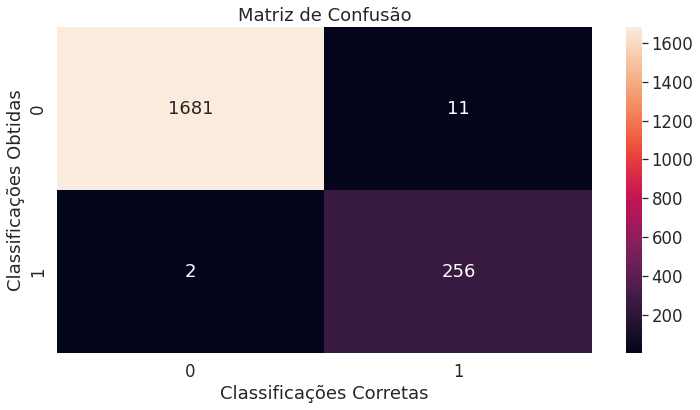

In [ ]:
cm = confusion_matrix(Y, predicoes)

ax = sns.heatmap(cm, annot=True, fmt='g');

ax.set_title('Matriz de Confusão');
ax.set_xlabel('Classificações Corretas')
ax.set_ylabel('Classificações Obtidas');
plt.show()